Let's start by importing the required libraries

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit
                                     , cross_val_score, GridSearchCV)
from sklearn.preprocessing import (Imputer, OneHotEncoder,StandardScaler,LabelEncoder)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils import check_array
from scipy import sparse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline


In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

We'll write a function to do the following:
* Check whether the folder containing the housing dataset already exists. If not, create a new folder
* Download the zip file from the specified url. If the dataset already exists, it will be replace by the latest
* Unzip the compressed file

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

We'll now load the data using the Pandas library. We'll make use of a function again to automate the script

In [6]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()

# Take a quick look at the Data Structure

Let's take a quick look at the data, by viewing the first 5 rows 

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The info() method is useful to get a quick description of the data, in particular the number of rows, the data types and the number of non-null values

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20 640 observations in the dataset. Only one of the variables (total_bedrooms) contain missing values. All the variables are numerical, except ocean_proximity. Let's see how many unique values this variable has and whether we can use it in our model

In [10]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's look at some summary statistics for the other fields

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's plot some histograms of the data

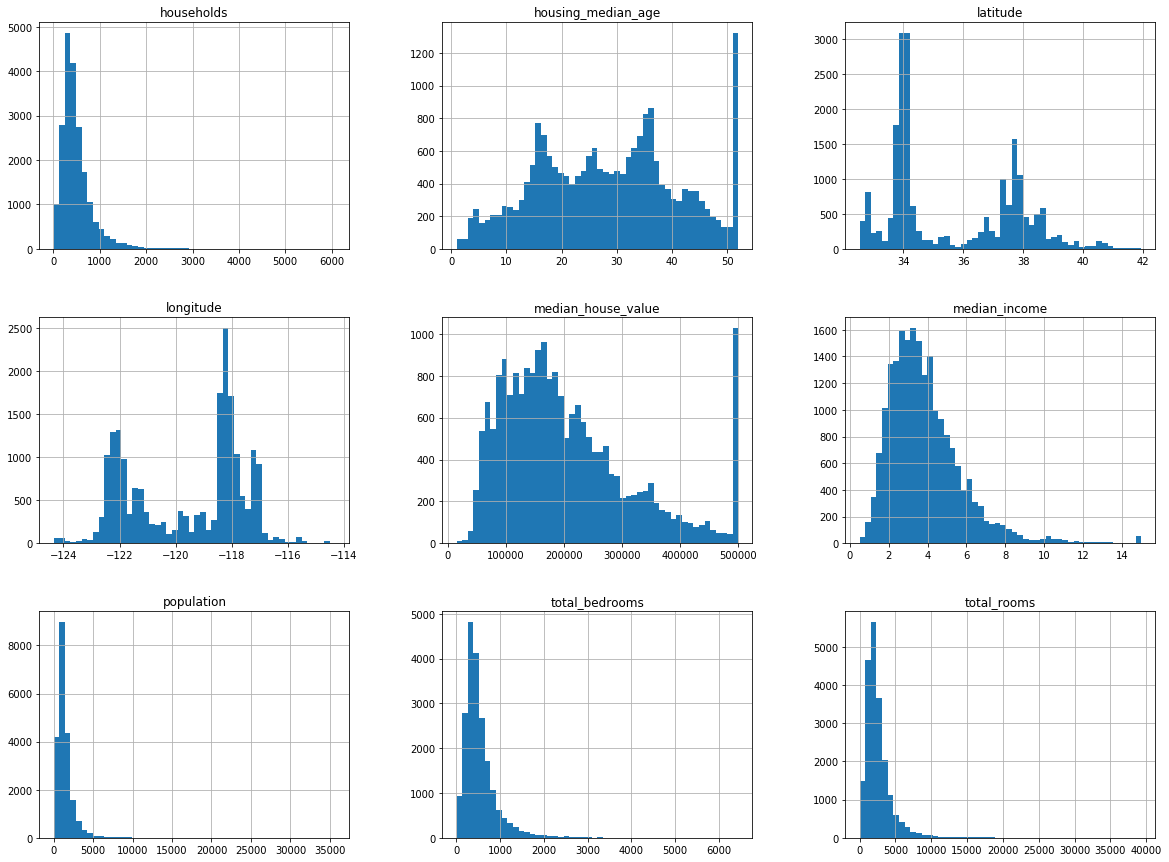

In [12]:
housing.hist(bins=50,figsize=(20,15))
plt.show()

Notice a few things in these histgrams:
* The median income has been scaled and capped at 15 for higher median income and at 0.5 for lower median incomes
* The housing median age and the median house price we also capped. This may pose a problem for the median house proce, since this is your target variable. Yout machine learning algorithm may learn that prices never go beyond that limit. 
* The variables have very different scales
* Finally, may histograms are tail heavy

# Create a test set

Before we do any more exploratory analysis, let's split our dataset into a training and test dataset. This is to avoid so called data snooping bias

In [13]:
def split_train_test(data,test_ratio,seed=12456):
    np.random.seed(seed=seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_train_test(housing,0.2)

In [15]:
print("Numer of observations in training set: {}".format(len(train_set)))
print("Numer of observations in test set: {}".format(len(test_set)))

Numer of observations in training set: 16512
Numer of observations in test set: 4128


In [16]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5024,-118.32,33.99,48.0,1260.0,284.0,791.0,280.0,2.1875,115200.0,<1H OCEAN
14772,-117.07,32.57,14.0,1527.0,357.0,1224.0,363.0,2.7361,93600.0,NEAR OCEAN
4571,-118.27,34.07,34.0,786.0,341.0,1239.0,320.0,2.3438,152100.0,<1H OCEAN
1548,-121.94,37.75,17.0,2559.0,370.0,1238.0,377.0,6.2781,269800.0,<1H OCEAN
1345,-121.90,38.00,14.0,1930.0,363.0,990.0,322.0,4.1094,162200.0,INLAND


Or we can just use the train_test_split function in Scikit-learn!

In [17]:
train_set, test_set = train_test_split(housing, test_size=0.2,random_state=12456)

Let's draw a stratified random sample based on the median income. Firstly we create 5 income categories

In [18]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0 , inplace=True)

Next we use sklearn's StratifiedShuffleSplit method to create a training and test set based on this stratification variable

In [19]:
split = StratifiedShuffleSplit(n_splits =1, test_size=0.2,random_state=1234)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]                                                          

Let's check whether the income category distributions are similar between the full dataset and the training set

In [20]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [21]:
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

Looks good. Let's drop the income_cat variable from the train and test sets

In [22]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

# Discover and visualize the data to gain insights

Let's create a copy of the training dataset so that we can play with it without affecting the training set

In [23]:
housing = strat_train_set.copy()

Since there is geographical information(latitude and longitude), it is a good idea to create a scaterplot of all districts to visualize the data

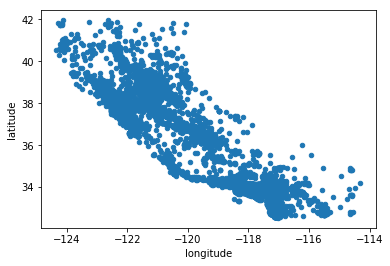

In [24]:
housing.plot(kind="scatter",x="longitude",y="latitude")

This looks like California all right, but other than that it is hard to see any paticular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places wehere these is a high density of data points

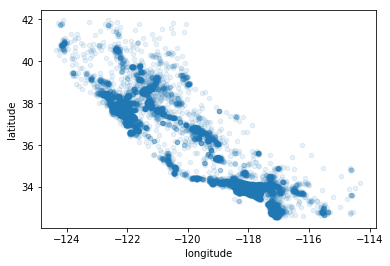

In [25]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

Now let's look at the housing proces. The radius of each cirlce represents the district's populaiton, and the colour represents the price

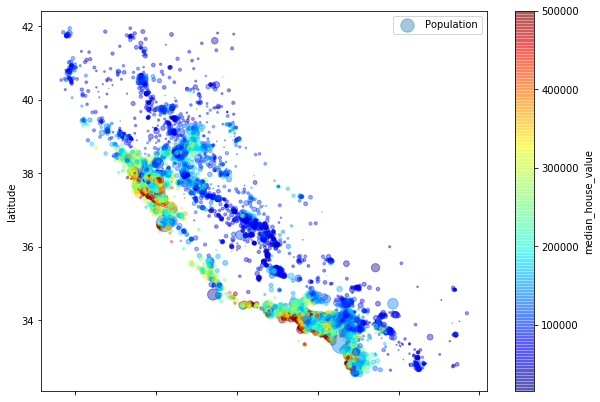

In [26]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,s=housing["population"]/100 \
             ,label = "Population", figsize =(10,7), c="median_house_value"\
             ,cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

The image tells you that the housing prices are very much reated to the location (e.g. close to the ocean) and to the population density. Let's plot the house prices on a map

Saving figure california_housing_prices_plot


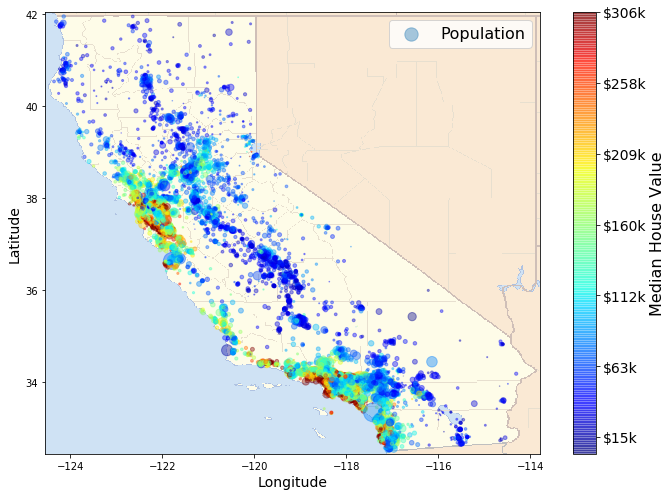

In [27]:
import matplotlib.image as mpimg
california_img=mpimg.imread('california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()


Since the dataset is not too large, we can compute the standard correlation coefficient bwteen every pair of variables using the corr() method. Otherwise we can use Spark 

In [28]:
corr_matrix = housing.corr()

In [29]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690077
total_rooms           0.131453
housing_median_age    0.099620
households            0.064110
total_bedrooms        0.048565
population           -0.023790
longitude            -0.047697
latitude             -0.144086
Name: median_house_value, dtype: float64

In [30]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [31]:
attributes = ['median_income','median_house_value','total_rooms','housing_median_age']

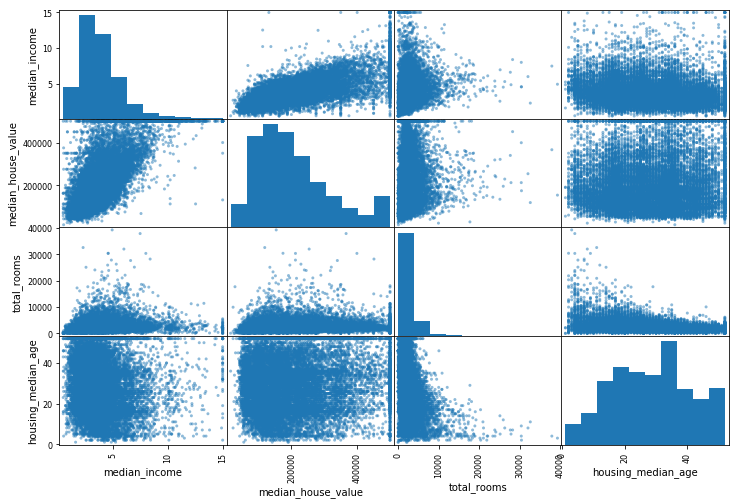

In [32]:
_ = scatter_matrix(housing[attributes],figsize=(12,8))


The most prominent variable to predict the median house price is the median income, so let's zoom in on their scatterplot

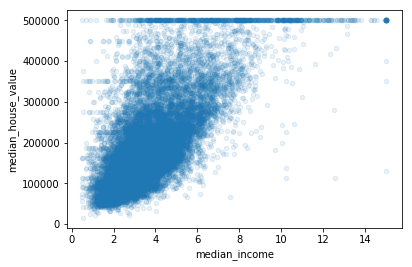

In [33]:
housing.plot(kind='scatter', x='median_income',y='median_house_value',alpha=0.1)

The plot reveal a few things, First the correlation is very strong. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500 000

# Experimenting with variable combinations

One last thing we may want to do before actually preparing the data for Machine learning algorithms is to try out various variable combinations. For example, the total number of rooms in a district is not very useful if you know how many housegolds there are. What you really want is the number of rooms per household. We'll create a few additional variables

In [34]:
housing['rooms_per_houshold'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
        
        

Let's looks at the correlation matrix again

In [35]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690077
rooms_per_houshold          0.153156
total_rooms                 0.131453
housing_median_age          0.099620
households                  0.064110
total_bedrooms              0.048565
population_per_household   -0.022425
population                 -0.023790
longitude                  -0.047697
latitude                   -0.144086
bedrooms_per_room          -0.261785
Name: median_house_value, dtype: float64

Not bad. The new variable bedrooms_per_room is much more correlated with the median house value than the variables that were used to derive this variable

# Data preparation

Let's first create 2 data sets: one containing the predictors and another the target variable

In [36]:
housing = strat_train_set.drop('median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()             

We saw earlier that the total_bedrooms variable had some missing values. Let's impute the missing values with the median value

In [37]:
imputer = Imputer(strategy='median')

In [38]:
housing_num = housing.drop('ocean_proximity',axis=1)

In [39]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [40]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2121.    ,  435.    , 1168.    ,
        410.    ,    3.5313])

In [41]:
X = imputer.transform(housing_num)

In [42]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns)

Next we'll convert the categorical variable to a numerical variable using one-hot encoding. We can use Pandas' factorize() method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

In [43]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded, housing_categories = housing_cat.factorize()


In [44]:
housing_cat_encoded[:10]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [45]:
housing_categories

Index(['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')

In [46]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very usefull when you have categorical variables with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for one 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matix only store the location of the nonzero elements

Currently there is no implemetation for doing one-hot encoding in one step in Scikit-Learn.  In the meantime you can use the code below (copied from [Pull Request #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)).

In [47]:

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [48]:
cat_encoder = CategoricalEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Custom Tranformers

Let's automated the feature engineering task by writing a small transformer class that adds the combined variables we discussed earlier

In [49]:
rooms_ix , bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        population_per_household = X[:,population_ix ]/ X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

In [50]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this variable helps the machine learning algorithms or not

# Transformation pipelines

As you can see, there are many data transformaitons steps that nees to be excuted in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Now it would be nice if we could feed a Pandas DaatFrame directly into our pipeline, instead of having to first manually extract the numerical columns into a NumPy array. There is nothing in Scikit-Learn to handle Pandas Dataframes, but we can wite a customer transformer for this task

In [51]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X[self.attribute_names].values

Our DataFrameSelector will tranform the data by selecting the desired variables, dropping the rest, and convert the resulting DataFrame to a NumPy array

We can now create two pipelines. One for the numerica variables and one for the categorical variables

In [52]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [53]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer' , Imputer(strategy='median')),
    ('arribs_adder', CombinedAttributesAdder()),
    ('std_scaler' , StandardScaler())
])

In [54]:
cat_pipeline = Pipeline([
     ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

To combine the two pipelines, we can make use of the FeatureUnion class

In [55]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])

Now we can run the whole pipeline simply

In [56]:
housing_prepared = full_pipeline.fit_transform(housing)

In [57]:
housing_prepared

array([[ 0.77177853, -0.86573405, -0.05126158, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95117413,  1.33356736, -0.29020894, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72683194, -0.83765786,  0.58593138, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.01110292,  1.93720541, -0.36985806, ...,  0.        ,
         0.        ,  0.        ],
       [-1.08101984,  0.40705315, -0.1309107 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23622665, -1.27751814, -1.00705102, ...,  0.        ,
         0.        ,  0.        ]])

# Select and train a model

Finally we're ready to build our first model!

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
housing_predictions = lin_reg.predict(housing_prepared)

In [60]:
lin_mse = mean_squared_error(housing_labels,housing_predictions)

In [61]:
print('MSE : {}'.format(lin_mse))
print('RMSE : {}'.format(np.sqrt(lin_mse)))

MSE : 4631551058.973512
RMSE : 68055.49984368282


Not good at all! Especially considering that the mean value and standard deviation from the training set are as follows:

In [62]:
print('Mean value from Training set: {}'.format(np.mean(housing_labels)))
print('Std  deviation from Training set: {}'.format(np.std(housing_labels)))

Mean value from Training set: 206562.60053294574
Std  deviation from Training set: 115166.60137705096


This is an example of a model underfitting the training data. The main way to fix underfitting is to:
* Select a more powerful model
* Feed the training algorithm with better features
* Reduce the number of constraints

The model is not regularized, so this rules out the last option. Wecould try to add more features, but let's first try a more complex model to see how it does.

# Better evaluation using cross evaluation

We can get a better idea of whether our models are overfitting by making use of a cross validation methodology

In [63]:
np.random.seed(seed=898942)

scores = cross_val_score(lin_reg,housing_prepared,housing_labels,\
                         scoring='neg_mean_squared_error', cv=10)

In [64]:
scores

array([-4.75846441e+09, -5.05363271e+09, -4.28958294e+09, -4.28498998e+09,
       -4.68726672e+09, -4.78297216e+09, -4.85393105e+09, -4.96118410e+09,
       -4.26503930e+09, -4.92556987e+09])

In [65]:
lin_reg_rmse_scores = np.sqrt(-scores) 

Let's look at the results

In [66]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std Dev:", scores.std())

In [67]:
display_scores(lin_reg_rmse_scores)

Scores: [68981.62370731 71088.90705755 65494.90770994 65459.83488055
 68463.61605192 69159.03526441 69670.15897848 70435.67350135
 65307.2683707  70182.40428775]
Mean: 68424.34298099727
Std Dev: 2091.0791372512435


Let's try a Random forest model

In [68]:
forest_reg = RandomForestRegressor(n_estimators=200,random_state=467)
scores = cross_val_score(forest_reg,housing_prepared,housing_labels,\
                         scoring='neg_mean_squared_error', cv=10)

In [69]:
rf_rmse_scores = np.sqrt(-scores) 

In [70]:
display_scores(rf_rmse_scores)

Scores: [49390.69274998 51746.87295591 47930.529608   46195.5103469
 50843.31959699 49402.08821706 50769.8547042  50202.02193198
 49655.47872636 47426.87144649]
Mean: 49356.32402838774
Std Dev: 1627.2167384510683


In [71]:
display_scores(rf_rmse_scores)

Scores: [49390.69274998 51746.87295591 47930.529608   46195.5103469
 50843.31959699 49402.08821706 50769.8547042  50202.02193198
 49655.47872636 47426.87144649]
Mean: 49356.32402838774
Std Dev: 1627.2167384510683


Much better! Let's fine tune our model by tweeking the hyperparameters. This can easily be done by Scikit-Learn's GridSearchCV method

# Grid search

In [72]:
param_grid = [
    {'n_estimators': [50,100,200], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators' : [50,100,200], 'max_features': [2,3,4]}
]

In [73]:
grid_search = GridSearchCV(forest_reg,param_grid,\
                         scoring='neg_mean_squared_error', cv=5,return_train_score=True)
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=467, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [50, 100, 200], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [50, 100, 200], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 200}

We get the best solution by setting the max_features hyperparameter to 4, the number of trees equal to 200 and the bootstrap option equal to False. We might get even a better fit by increasing the number of trees that are fitted. We can print out the RMSE for each of the combinations

In [75]:
cvres = grid_search.cv_results_

In [76]:
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

51529.18993582012 {'max_features': 2, 'n_estimators': 50}
51195.82017642011 {'max_features': 2, 'n_estimators': 100}
50953.03800369905 {'max_features': 2, 'n_estimators': 200}
49660.70102019521 {'max_features': 4, 'n_estimators': 50}
49087.60933618507 {'max_features': 4, 'n_estimators': 100}
48930.79015441135 {'max_features': 4, 'n_estimators': 200}
49085.71012793174 {'max_features': 6, 'n_estimators': 50}
48602.982458003826 {'max_features': 6, 'n_estimators': 100}
48502.663271517726 {'max_features': 6, 'n_estimators': 200}
49358.707009778635 {'max_features': 8, 'n_estimators': 50}
48723.73343652327 {'max_features': 8, 'n_estimators': 100}
48618.66802986888 {'max_features': 8, 'n_estimators': 200}
50483.8966419881 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
49986.74846768074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
49925.4422765717 {'bootstrap': False, 'max_features': 2, 'n_estimators': 200}
48813.02919665538 {'bootstrap': False, 'max_features': 3, '

In [77]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.102916,0.050680,-2.655257e+09,-3.892534e+08,NaN,2,50,"{'max_features': 2, 'n_estimators': 50}",21,-2.829560e+09,...,-2.781187e+09,-3.859047e+08,-2.742487e+09,-3.882962e+08,-2.504296e+09,-3.922128e+08,0.037923,0.001757,1.628319e+08,3.803059e+06
1,2.273143,0.102116,-2.621012e+09,-3.699821e+08,NaN,2,100,"{'max_features': 2, 'n_estimators': 100}",20,-2.752476e+09,...,-2.743260e+09,-3.670982e+08,-2.711397e+09,-3.682839e+08,-2.511335e+09,-3.758881e+08,0.106048,0.004895,1.465422e+08,5.257710e+06
2,4.399571,0.186248,-2.596212e+09,-3.594454e+08,NaN,2,200,"{'max_features': 2, 'n_estimators': 200}",19,-2.722453e+09,...,-2.720869e+09,-3.587079e+08,-2.689457e+09,-3.560501e+08,-2.473692e+09,-3.646131e+08,0.096832,0.006042,1.444251e+08,4.402961e+06
3,1.749898,0.047659,-2.466185e+09,-3.583072e+08,NaN,4,50,"{'max_features': 4, 'n_estimators': 50}",15,-2.551543e+09,...,-2.584788e+09,-3.588783e+08,-2.553771e+09,-3.495270e+08,-2.359126e+09,-3.660437e+08,0.018994,0.003026,1.220764e+08,6.544826e+06
4,3.556244,0.094641,-2.409593e+09,-3.378500e+08,NaN,4,100,"{'max_features': 4, 'n_estimators': 100}",13,-2.488206e+09,...,-2.522132e+09,-3.371205e+08,-2.509539e+09,-3.338308e+08,-2.315129e+09,-3.446197e+08,0.102284,0.009193,1.236220e+08,5.048745e+06
5,7.133442,0.176797,-2.394222e+09,-3.287492e+08,NaN,4,200,"{'max_features': 4, 'n_estimators': 200}",11,-2.490220e+09,...,-2.509170e+09,-3.287711e+08,-2.492453e+09,-3.236431e+08,-2.304322e+09,-3.345213e+08,0.189618,0.002426,1.328398e+08,4.474436e+06
6,2.447245,0.048827,-2.409407e+09,-3.495472e+08,NaN,6,50,"{'max_features': 6, 'n_estimators': 50}",12,-2.522002e+09,...,-2.512331e+09,-3.462267e+08,-2.561308e+09,-3.471692e+08,-2.277126e+09,-3.504103e+08,0.072946,0.001921,1.543518e+08,3.448612e+06
7,4.876813,0.090465,-2.362250e+09,-3.313740e+08,NaN,6,100,"{'max_features': 6, 'n_estimators': 100}",7,-2.472584e+09,...,-2.462141e+09,-3.272743e+08,-2.489830e+09,-3.289636e+08,-2.254945e+09,-3.364866e+08,0.052554,0.002227,1.435716e+08,3.409476e+06
8,9.761521,0.178162,-2.352508e+09,-3.228916e+08,NaN,6,200,"{'max_features': 6, 'n_estimators': 200}",4,-2.439866e+09,...,-2.456748e+09,-3.194248e+08,-2.480038e+09,-3.209822e+08,-2.257883e+09,-3.276344e+08,0.032579,0.004973,1.371885e+08,3.296272e+06
9,3.108212,0.045608,-2.436282e+09,-3.500168e+08,NaN,8,50,"{'max_features': 8, 'n_estimators': 50}",14,-2.508810e+09,...,-2.534122e+09,-3.479636e+08,-2.544141e+09,-3.433755e+08,-2.382919e+09,-3.577473e+08,0.045610,0.001480,1.263840e+08,5.475126e+06


The smallest RMSE value we get, is 47 976. Lastly we can see which variables are the most predictive

In [78]:
feature_importance = grid_search.best_estimator_.feature_importances_

In [79]:
feature_importance


array([9.19135256e-02, 8.61406380e-02, 4.03835185e-02, 2.15411510e-02,
       1.91172627e-02, 2.11779406e-02, 1.86115872e-02, 2.88965156e-01,
       7.04903404e-02, 9.77191375e-02, 8.31653057e-02, 1.86633760e-02,
       1.28688220e-01, 2.65277864e-04, 4.80910658e-03, 8.34845544e-03])

In [80]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

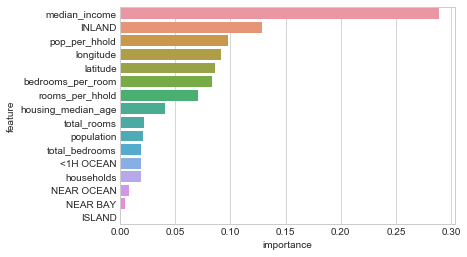

In [81]:
fi_for_draw = pd.DataFrame({'feature': attributes, 'importance':feature_importance})
fi_for_draw = fi_for_draw.sort_values(by="importance", ascending=False)
sns.set_style("whitegrid")
sns.barplot(data=fi_for_draw, x='importance', y='feature')
plt.show()

From the above plot we see  median_income is the most predictive, followed by the whether the property is located inland.
 

# Evaluate your model on the test set

Finally it's time to evaluate your model on the test set

In [83]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value',axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_predictions)
print('Test RMSE: {}'.format(np.sqrt(final_mse)))

Test RMSE: 49224.92073783939
